# BT2101 Introduction to Decision Tree

# This assignment should be run in Python-2.7 version. If you run in Python 3+, you will get errors. In Anaconda, you could easily create a new virtual environment with Python-2.7.

## 1 Goal

In this notebook, we will explore **Decision Tree** including:
* User-defined functions
* Open-source package: `scikit-learn`

For the **Decision Tree** method, you will:
* Use numpy to write functions
* Write binary recursive splitting functions
* Write decision functions
* Write pruning functions
* Use open-source package to do classification

In [1]:
# -*- coding:utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt, log
from __future__ import division
from collections import defaultdict
%matplotlib inline

## 2 Summary of Classification Tree

#### Classification Tree
A typical classification tree looks like this:
<img src="https://cdn-images-1.medium.com/max/750/1*2jnsFCe0YmRjb8EvVAo93w.gif" width="500">

#### Steps for Binary Splitting (E.g., Entropy)
1. Compute the entropy for data-set;
2. For every attribute/feature, calculate information gain for this attribute;
3. Pick the feature with highest information gain;
4. Repeat until we get the tree we desired;

#### Entropy and Information Gain
<img src="https://cdn-images-1.medium.com/max/2000/1*EoWJ8bxc-iqBS-dF-XxsBA.jpeg" width="900">
<img src="https://cdn-images-1.medium.com/max/2000/1*wQjVzx7zCVb87htqk46vUA.jpeg" width="900">

#### Alternative Criterion for Binary Splitting
There are a few possible criteria we can use for selecting features and making the binary splits of classification decision tree:
* Classification Error Rate
* Gini Index

## 3 Case: Kaggle Competition - Lending Club Loan Status
### 3.1 Data

#### Overview
The file "LoanStats_2018Q1.csv" contains complete loan data for all loans issued through the 2018 Quarter-1, including the current loan status (Current, Late, Fully Paid, etc.) and latest payment information. The file containing loan data through the "present" contains complete loan data for all loans issued through the previous completed calendar quarter. Additional features include credit scores, number of finance inquiries, address including zip codes, and state, and collections among others.  <br/>
Please see https://www.kaggle.com/wendykan/lending-club-loan-data/home.

#### Attributes
The dataset can be downloaded [here](https://www.lendingclub.com/info/download-data.action). Information on the columns and features can be found in data dictionary. A data dictionary is provided in a separate file "LCDataDictionary.xlsx".

#### Goal
Our goal is to show how to do binary splitting and tree pruning for a classification tree.

#### Selected Features
For the sake of simplicity, We only select 3 categorical variables as features. We will further transform these categorical variables into binary ones. You need to learn how to fit decision trees when features are continuous variables. 

### 3.2 Build Tree

#### Function 1. Calculating entropy value of a given tree node with labels of samples.

In [2]:
def entropy(sample_labels):
    '''This function is used to calculate entropy value of a given tree node, in which there are samples with labels (0, 1) or (-1, 1).
    Inputs:
    1) sample_labels: Labels for samples in the current tree node, such as (1, 0, 0, 1, 0) or (1, -1, -1, 1, 0)
    
    Outputs:
    1) entropy: Entropy value of labels in the current tree node.       
    
    '''
    
    # Assert np.array
    sample_labels = np.array(sample_labels)
    
    # What if sample_labels are empty
    if sample_labels.size == 0:
        return 0  
    
    # What if all the labels are the same
    class_values = np.unique(sample_labels) # Sample labels/classes; Usually (0,1), sometimes (-1,1)
    num0 = len(filter(lambda x:x==class_values[0], sample_labels)) # Number of samples with one label
    num1 = len(filter(lambda x:x==class_values[1], sample_labels)) if class_values.size > 1 else 0 # Number of samples with another label
    
    if sample_labels.size == num0 or sample_labels.size == num1:
        return 0
    
    # Calculate entropy value      
    p0 = num0 / (num0+num1) # Probability of class 0 labels
    p1 = 1 - p0 # Probability of class 1 labels
    
    entropy = -(p0*log(p0,2) + p1*log(p1,2))    
    
    return entropy

#### Function 2. Calculating information gain when a given tree node is splitted by a given feature

In [3]:
def info_gain(samples, output, feature):
    '''This function is used to calculate information gain when a given tree node is splitted by a given feature.
    Inputs:
    1) samples: Samples in the current tree node before making split on the feature (Pandas Dataframe)
    1) output: Name of the output column
    2) feature: Name of the feature used to split the current tree node. Remember the features we selected in this case are binary.
    
    Outputs:
    1) information_gain: How much reduction in entropy value if the current tree node is splitted by the feature 
    2) subsamples[0]: Data samples where feature values are one label (e.g., 0 or -1)
    3) subsamples[1]: Data samples where feature values are another label (e.g., 1)
    
    '''
    
    # Split samples by feature values into subsamples
    subsamples = defaultdict()
    entropy_after = 0 # Entropy value after splitting
    
    for feature_value in np.unique(samples[feature]):
        subsamples[feature_value] = samples[samples[feature] == feature_value]
        temp = subsamples[feature_value] # Store a temporary copy
        p = len(temp) / len(samples) # Proportion of this subsample
        entropy_after += p * entropy(temp[output])
        
    # Calculate information gain 
    information_gain = entropy(samples[output]) - entropy_after
    
    # Left or Right subtree may be None  
    return (information_gain, subsamples[0] if 0 in subsamples else None, subsamples[1] if 1 in subsamples else None)  

In [4]:
# Let us have a test
a = np.array([[1,0,0,1],[0,1,1,0],[1,1,1,1],[0,0,0,0],[1,1,0,0]])
data = pd.DataFrame(a, columns=['x1','x2','x3','y'])
info_gain(data, 'y', 'x1')[1]

,x1,x2,x3,y
1,0,1,1,0
3,0,0,0,0


In [5]:
# Let us have a test
a = np.array([[1,0,0,1],[1,1,1,0],[1,1,1,1],[1,0,0,0],[1,1,0,0]])
data = pd.DataFrame(a, columns=['x1','x2','x3','y'])
info_gain(data, 'y', 'x1')

(0.0, None,    x1  x2  x3  y
 0   1   0   0  1
 1   1   1   1  0
 2   1   1   1  1
 3   1   0   0  0
 4   1   1   0  0)

#### Why is information gain nonnegative?
Math Proof: https://www.cs.cmu.edu/~ggordon/780-fall07/fall06/homework/15780f06-hw4sol.pdf

#### Function 3. Decide the best feature to split on: Using information gain and entropy as criterion
1. Loop over each feature in the feature list;
2. For each loop (feature f), split the data into 2 groups: In group 1 (left split), all samples' feature f has value 0. In group 2 (right split), all samples' feature f has value 1;
3. Calculate the information gain for this split;
4. If the information gain for this split using this feature is highest, then pick this feature.

In [6]:
def best_feature_split(samples, output, features):
    '''This function is used to determine the best feature to split based on maximized information gain.
    Inputs:
    1) samples: Samples in the current tree node before making split on the feature (Pandas Dataframe)
    2) output: Name of the output column
    3) features: A list of feature names
    
    Outputs:
    1) best_feature: The best feature which is used to do binary splitting
    2) best_left_split: Data samples where the best feature's values are 0
    3) best_right_split: Data samples where the best feature's values are 1      
    
    '''
    
    # Initialize best feature, best information gain value, best left/right split samples
    best_feature = None 
    best_information_gain = 0
    best_left_split = None
    best_right_split = None    
    
    samples_row = float(len(samples)) # Number of rows in the data samples
    
    # Loop through features and find the best feature
    for feature in features:
        
        # Splitting the data samples
        current_split = info_gain(samples, output, feature)
        information_gain = current_split[0]
        left_split = current_split[1]
        right_split = current_split[2]
        
        # Check if this feature is better
        if information_gain >= best_information_gain:
            best_feature, best_information_gain, best_left_split, best_right_split = feature, information_gain, left_split, right_split
    
    return (best_feature, best_information_gain, best_left_split, best_right_split)

In [7]:
# Let us have a test
a = np.array([[1,0,0,1],[0,1,1,0],[1,1,1,1],[0,0,0,0],[1,1,0,0]])
data = pd.DataFrame(a, columns=['x1','x2','x3','y'])
best_feature_split(data, 'y', ['x1','x2','x3'])

('x1', 0.4199730940219749,    x1  x2  x3  y
 1   0   1   1  0
 3   0   0   0  0,    x1  x2  x3  y
 0   1   0   0  1
 2   1   1   1  1
 4   1   1   0  0)

In [8]:
a = np.array([[1,0,0,1],[1,1,1,0],[1,1,1,1],[1,0,0,0],[1,1,0,0]])
data = pd.DataFrame(a, columns=['x1','x2','x3','y'])
best_feature_split(data, 'y', ['x1','x2','x3'])

('x3', 0.01997309402197489,    x1  x2  x3  y
 0   1   0   0  1
 3   1   0   0  0
 4   1   1   0  0,    x1  x2  x3  y
 1   1   1   1  0
 2   1   1   1  1)

#### Function 4. Build our classification tree and do pre-pruning
We need to decide stopping conditions (i.e., pre-pruning):
1. The samples' labels in the current node are the same (either 0 or 1);
2. All the features have already been used for split;
3. The current tree has already reached maximum depth **max_depth**;
4. The number of samples in the current node is lower than minimum number **min_number**;
5. The information gain for the current split is lower than a threshold **min_infogain** 

##### Stopping Condition 1: The samples' labels in the current node are the same (either 0/-1 or 1)

In [9]:
def stop_1(node_labels):
    '''This function is used to verify whether stopping condition 1 is satisfied.
    Inputs:
    1) node_labels: The samples' labels in the current node
    
    Outputs:
    1) True if they are all the same, False if otherwise
    
    '''
    
    # numpy array
    node_labels = np.array(node_labels)
    
    # Empty labels
    if len(node_labels) == 0:
        return True
    
    if len(np.unique(node_labels)) == 1:
        print "Stopping Condition 1: The samples' labels in the current node are the same (either 0/-1 or 1)"
        return True
    else:
        return False

##### Stopping Condition 2: All the features have already been used for split

In [10]:
def stop_2(features):
    '''This function is used to verify whether stopping condition 2 is satisfied.
    Inputs:
    1) features: A list of feature names
    
    Outputs:
    1) True if the feature list is empty, False if otherwise
    
    '''
    
    if len(features) == 0 or features == None:
        print "Stopping Condition 2: All the features have already been used for split"
        return True
    else:
        return False  

##### Stopping Condition 3: The current tree has already reached maximum depth **max_depth**

In [11]:
def stop_3(tree_depth, max_depth):
    '''This function is used to verify whether stopping condition 3 is satisfied.
    Inputs:
    1) tree_depth: The depth of the current tree
    2) max_depth: Maximum tree depth
    
    Outputs:
    1) True if the current depth reaches maximum depth, False if otherwise
    
    '''
    
    if tree_depth >= max_depth:
        print "Stopping Condition 3: The current tree has already reached maximum depth"
        return True
    else:
        return False  

##### Stopping Condition 4: The number of samples in the current node is lower than minimum number **min_number**

In [12]:
def stop_4(samples, min_number):
    '''This function is used to verify whether stopping condition 4 is satisfied.
    Inputs:
    1) samples: Data samples in the current node (Pandas DataFrame)
    2) min_number: Minimum number of node size
    
    Outputs:
    1) True if sample size is smaller than the minimum number, False if otherwise
    
    '''
    
    if samples.size <= min_number:
        print "Stopping Condition 4: The number of samples in the current node is lower than minimum number"
        return True
    else:
        return False      

##### Stopping Condition 5: The information gain for the current split is lower than a threshold **min_infogain** 

In [13]:
# info_gain(samples, output, feature) -> information gain, left, right
# best_feature_split(samples, output, features) -> feature, information gain, left, right
def stop_5(info_gain, min_infogain):
    '''This function is used to verify whether stopping condition 5 is satisfied.
    Inputs:
    1) info_gain: Information gain after this best split
    2) min_infogain: Minimum information gain
    
    Outputs:
    1) True if information gain after this best splitting is smaller than the minimum number, False if otherwise
    
    '''
    
    if info_gain <= min_infogain:
        print "Stopping Condition 5: The information gain for the current split is lower than a threshold"
        return True
    else:
        return False      

##### Build classification tree
The data structure for the nested tree structure (including temporary tree nodes, and leaf nodes) is shown as:

{ <br/>
   'label': None for temporary node, or predicted label at the leaf node (e.g., "Majority Voting" criterion) for leaf node; <br/>
   'left_tree': Left tree after the selected feature (=0 or -1) is splitted for temporary node, None for leaf node; <br/>
   'right_tree': Right tree after the selected feature (=1) is splitted for temporary node, None for leaf node; <br/>
   'best_feature': The feature that is selected to do binary split for temporary node, None for leaf node. <br/>
}

In [14]:
def majority_vote(output_labels):
    '''This function is used to get predicted label based on "Majority Voting" criterion for the current leaf node.     
    Inputs:
    1) output_labels: Outputs (labels) in this leaf node, such as [1, 0, 0, 1, 1]
    
    Outputs:
    1) prediction: Predicted label for this leaf node (e.g., 0/-1, or 1)
    
    '''
    
    # numpy array
    output_labels = np.array(output_labels)
    
    # Empty label
    if output_labels.size == 0:
        return None
    
    # Count output labels (0/-1 or 1)
    values = np.unique(output_labels)
    
    if len(values) == 1:
        return values[0]
    else:
        num0 = len(output_labels[output_labels == values[0]])
        num1 = len(output_labels[output_labels == values[1]])
        return values[1] if num1 >= num0 else values[0] # Prediction based on "Majority Voting" criterion   

In [15]:
def ClassificationTree(samples, output, features, step, tree_depth, max_depth, min_number, min_infogain):
    '''This function is used to build a classification tree in a recursive way.
       Remember how you build a binary tree in the previous C++ and Data Structure courses).
       
    Inputs:
    1) samples: Samples in the current tree node before making split on the feature (Pandas Dataframe)
    2) output: Name of the output column
    3) features: A list of feature names
    4) step: The current binary split step
    5) tree_depth: The depth of the current tree
    6) max_depth: Maximum depth this tree can grow
    7) min_number: Minimum number of node size
    8) min_infogain: Minimum information gain
    
    Outputs:
    1) tree_nodes: Nested tree nodes, which are stored and shown in nested dictionary type    
    
    '''
    
    # If samples are empty, return None
    if samples is None or len(samples)==0:
        return None
           
    
    current_features = features # Current feature list
    labels = samples[output] # Output labels in the current tree node

    print "----------------------------------------------------------------------------"
    print "----------------------------------------------------------------------------"
    print "Step %s: Current tree depth is %s. Current tree node has %s data points" % (step, tree_depth, len(samples)) # Sample size
    
    # Verify whether stopping conditions 1-4 are satisfied. If satisfied, return a leaf_node
    if stop_1(labels) or stop_2(current_features) or stop_3(tree_depth, max_depth) or stop_4(samples, min_number):
        return {
                'label': majority_vote(labels),
                'left_tree': None,
                'right_tree': None,
                'best_feature': None          
            
                }
    
    # If pass stopping conditions 1-4, then do best splitting
    best_split = best_feature_split(samples, output, current_features)
    best_feature, best_infogain, best_left, best_right = best_split[0], best_split[1], best_split[2], best_split[3]
    
    # Verify whether stopping condition 5 is satisfied. If satisfied, return a leaf node
    if stop_5(best_infogain, min_infogain):
        return {
                'label': majority_vote(labels),
                'left_tree': None,
                'right_tree': None,
                'best_feature': None          
            
                } 
    
    # If pass stopping condition 5, then move on
    step += 1
    print "Step %s: Binary split on %s. Size of Left and Right tree is (%s, %s)" % \
          (step, best_feature, len(best_left) if best_left is not None else 0, len(best_right) if best_right is not None else 0)
    current_features.remove(best_feature) # Remove this feature if this feature is used for split
    
    # Do binary split on left tree and right tree in a recursive way
    left_split = ClassificationTree(best_left, output, current_features, step+1, tree_depth+1, max_depth, min_number, min_infogain) 
    right_split = ClassificationTree(best_right, output, current_features, step+1, tree_depth+1, max_depth, min_number, min_infogain) 
    
    return {
            'label': None,
            'left_tree': left_split,
            'right_tree': right_split,
            'best_feature': best_feature        
            
            }  

### 3.3 Data Cleaning

### Data cleaning work is not a main issue for this assignment

In [16]:
%pwd
loan_data = pd.read_csv("./LoanStats_2018Q1.csv", low_memory=False, header=1)
loan_data.head(n=10)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,20000.0,20000.0,20000.0,36 months,10.41%,649.21,B,B3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,11000.0,11000.0,11000.0,36 months,7.34%,341.37,A,A4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,12000.0,12000.0,12000.0,36 months,6.07%,365.45,A,A2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,35000.0,35000.0,35000.0,36 months,16.01%,1230.67,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,20000.0,20000.0,20000.0,60 months,9.92%,424.16,B,B2,...,NaN,NaN,DirectPay,N,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,20000.0,20000.0,20000.0,60 months,17.47%,502.12,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,3000.0,3000.0,3000.0,36 months,10.41%,97.39,B,B3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,30000.0,30000.0,30000.0,36 months,7.34%,930.99,A,A4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,20000.0,20000.0,20000.0,60 months,26.77%,607.97,E,E5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,12000.0,12000.0,12000.0,60 months,18.45%,307.67,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# Select features and output
features = ['grade', 'term', 'home_ownership']       
output = 'risky'
loan_data = loan_data[loan_data['loan_status'] != 'Current']
loan_data[output] = loan_data['loan_status'].map(lambda x: 1 if x in ['Late (31-120 days)', 'Late (16-30 days)', 'Charged Off'] else 0)

In [18]:
dataset = loan_data[features+[output]]
dataset.head()

,grade,term,home_ownership,risky
37,A,36 months,RENT,0
83,C,36 months,RENT,0
99,B,36 months,OWN,0
112,D,36 months,RENT,0
135,D,36 months,RENT,1


In [19]:
# Transform categorical features to binary features
grade_dummy = pd.get_dummies(dataset['grade'], prefix='grade')  
term_dummy = pd.get_dummies(dataset['term'], prefix='term')
home_ownership_dummy = pd.get_dummies(dataset['home_ownership'], prefix='home_ownership')

In [20]:
dataset = dataset.join([grade_dummy, term_dummy, home_ownership_dummy])
dataset = dataset.drop(features, axis=1)

In [21]:
dataset = dataset.dropna() # Remove all missing values

In [22]:
dataset = dataset.reset_index() # Reset indexes

In [23]:
print dataset[output].value_counts() # Very unbalanced dataset
dataset.head(n=5)

0    5789
1    1161
Name: risky, dtype: int64


,index,risky,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,term_ 36 months,term_ 60 months,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT
0,37,0,1,0,0,0,0,0,0,1,0,0,0,0,1
1,83,0,0,0,1,0,0,0,0,1,0,0,0,0,1
2,99,0,0,1,0,0,0,0,0,1,0,0,0,1,0
3,112,0,0,0,0,1,0,0,0,1,0,0,0,0,1
4,135,1,0,0,0,1,0,0,0,1,0,0,0,0,1


## Note that you need to do oversampling on rare outputs (which is '1' in this example)
## Otherwise the tree nodes will always predict 0 (according to majority voting method)
## That will be problematic.

In [24]:
# Update our features and output

import copy
dataset_copy = copy.deepcopy(dataset) # Please note the difference between shallow copy and deep copy in Python

features = list(dataset_copy.columns[2:])
output = dataset_copy.columns[1]

In [25]:
dataset_copy.head(n=5)

,index,risky,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,term_ 36 months,term_ 60 months,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT
0,37,0,1,0,0,0,0,0,0,1,0,0,0,0,1
1,83,0,0,0,1,0,0,0,0,1,0,0,0,0,1
2,99,0,0,1,0,0,0,0,0,1,0,0,0,1,0
3,112,0,0,0,0,1,0,0,0,1,0,0,0,0,1
4,135,1,0,0,0,1,0,0,0,1,0,0,0,0,1


In [26]:
# Address Unbalanced data: Oversampling

# You may need to set seed first, otherwise if you use different training data to train the model, you will get different tree model
# and you may get different post-pruning results
import random
random.seed(12345)

# Class count
count_class_0, count_class_1 = dataset_copy[output].value_counts()

# Divide by class
df_class_0 = dataset_copy[dataset_copy[output] == 0]
df_class_1 = dataset_copy[dataset_copy[output] == 1]

# Address unblanced data issue: Oversampling on data samples with rare outputs (which is '1' in this example)
df_class_1_over = df_class_1.sample(count_class_0, replace=True, random_state=12345)
dataset_copy = pd.concat([df_class_1_over, df_class_0], axis=0)

dataset_copy[output].value_counts()

1    5789
0    5789
Name: risky, dtype: int64

In [27]:
dataset_copy.to_csv('./dataset.csv', index=None) # Store a copy: Export dataset to csv file

In [28]:
dataset_copy.head()

,index,risky,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,term_ 36 months,term_ 60 months,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT
3144,60094,1,0,0,0,1,0,0,0,1,0,0,1,0,0
1049,23326,1,0,0,0,0,1,0,0,0,1,0,0,0,1
2586,51737,1,0,0,1,0,0,0,0,1,0,0,1,0,0
3490,65224,1,0,0,0,0,0,1,0,0,1,0,1,0,0
4818,83747,1,0,0,0,0,1,0,0,0,1,0,1,0,0


### 3.4 Classification and Simple Visualization

In [29]:
# Suppose max_depth = 6; min_infogain=5e-4
# You can set other parameter values
features = list(dataset_copy.columns[2:])
output = dataset_copy.columns[1]
tree_model = ClassificationTree(dataset_copy, output, features, step=0, tree_depth=0, max_depth=7, min_number=5, min_infogain=5e-4)

----------------------------------------------------------------------------
----------------------------------------------------------------------------
Step 0: Current tree depth is 0. Current tree node has 11578 data points
Step 1: Binary split on grade_A. Size of Left and Right tree is (9844, 1734)
----------------------------------------------------------------------------
----------------------------------------------------------------------------
Step 2: Current tree depth is 1. Current tree node has 9844 data points
Step 3: Binary split on grade_B. Size of Left and Right tree is (7280, 2564)
----------------------------------------------------------------------------
----------------------------------------------------------------------------
Step 4: Current tree depth is 2. Current tree node has 7280 data points
Step 5: Binary split on home_ownership_MORTGAGE. Size of Left and Right tree is (4317, 2963)
--------------------------------------------------------------------------

In [30]:
tree_model

{'best_feature': 'grade_A',
 'label': None,
 'left_tree': {'best_feature': 'grade_B',
  'label': None,
  'left_tree': {'best_feature': 'home_ownership_MORTGAGE',
   'label': None,
   'left_tree': {'best_feature': 'grade_C',
    'label': None,
    'left_tree': {'best_feature': None,
     'label': 1,
     'left_tree': None,
     'right_tree': None},
    'right_tree': {'best_feature': 'term_ 60 months',
     'label': None,
     'left_tree': {'best_feature': 'home_ownership_OWN',
      'label': None,
      'left_tree': {'best_feature': 'home_ownership_RENT',
       'label': None,
       'left_tree': {'best_feature': None,
        'label': 0,
        'left_tree': None,
        'right_tree': None},
       'right_tree': {'best_feature': None,
        'label': 1,
        'left_tree': None,
        'right_tree': None}},
      'right_tree': {'best_feature': None,
       'label': 1,
       'left_tree': None,
       'right_tree': None}},
     'right_tree': {'best_feature': None,
      'label': 1,


### Visualize the Tree

The data structure for the nested tree structure (including temporary tree nodes, and leaf nodes) is shown as:

{ <br/>
   'label': None for temporary node, or predicted label at the leaf node (e.g., "Majority Voting" criterion) for leaf node; <br/>
   'left_tree': Left tree after the selected feature (=0 or -1) is splitted for temporary node, None for leaf node; <br/>
   'right_tree': Right tree after the selected feature (=1) is splitted for temporary node, None for leaf node; <br/>
   'best_feature': The feature that is selected to do binary split for temporary node, None for leaf node. <br/>
}

In [31]:
def print_tree(tree, depth=0, LR=0):
    '''This function is used to visualize the tree model
    
    Inputs:
    1) tree: tree model
    2) depth: 
    3) LR: Left_subtree: feature=0; Right_subtree: feature=1
    
    Outputs:
    1) Print the tree model structure (i.e., nested dictionary)      
    
    '''
    
    if depth==0: # Root node
        print tree['best_feature']
        print_tree(tree['left_tree'], depth+1, 0)
        print_tree(tree['right_tree'], depth+1, 1)
        
    else:
        if tree['best_feature'] is not None: # Not leaf node
            print "\t" * depth, "=%s :" %(LR), tree['best_feature']
            try:
                print_tree(tree['left_tree'], depth+1, 0)
            except:
                pass
            try:
                print_tree(tree['right_tree'], depth+1, 1)   
            except:
                pass
            
        else:
            print "\t" * depth, "=%s : -" %(LR), "(Predict %s)" %(tree['label']) # Leaf node      
                
print_tree(tree_model, depth=0, LR=0)

grade_A
	=0 : grade_B
		=0 : home_ownership_MORTGAGE
			=0 : grade_C
				=0 : - (Predict 1)
				=1 : term_ 60 months
					=0 : home_ownership_OWN
						=0 : home_ownership_RENT
							=0 : - (Predict 0)
							=1 : - (Predict 1)
						=1 : - (Predict 1)
					=1 : - (Predict 1)
			=1 : grade_G
				=0 : grade_F
					=0 : grade_E
						=0 : - (Predict 0)
						=1 : term_ 36 months
							=0 : - (Predict 1)
							=1 : - (Predict 0)
					=1 : - (Predict 1)
				=1 : - (Predict 1)
		=1 : - (Predict 0)
	=1 : - (Predict 0)


#### Assignments:

Set your own stopping conditions for pre-pruning, For example: 
* You can adjust initial parameter values for these stopping conditions.
* Limiting the number of binary-split.

Choose one of them and describe or write your function/code.

In [32]:
# Suppose: Limiting the number of binary-split
# Note that python cannot define a static variable (unless you define it in python "Class" method)
# You can also count how many variables have already been used for splitting. This number is equal to the number of splits

def ClassificationTree(samples, output, features, step, tree_depth, max_depth, min_number, min_infogain, counter, max_split):
    '''This function is used to build a classification tree in a recursive way.
       Remember how you build a binary tree in the previous C++ and Data Structure courses).
       
    Inputs:
    1) samples: Samples in the current tree node before making split on the feature (Pandas Dataframe)
    2) output: Name of the output column
    3) features: A list of feature names
    4) step: The current binary split step
    5) tree_depth: The depth of the current tree
    6) max_depth: Maximum depth this tree can grow
    7) min_number: Minimum number of node size
    8) min_infogain: Minimum information gain
    9) counter: Indicate this is nth split
    10) max_split: Maximum number of splits
    
    Outputs:
    1) tree_nodes: Nested tree nodes, which are stored and shown in nested dictionary type    
    
    '''
    
    # If samples are empty, return None
    if samples is None or len(samples)==0:
        return None
           
    
    current_features = features # Current feature list
    labels = samples[output] # Output labels in the current tree node

    print "----------------------------------------------------------------------------"
    print "----------------------------------------------------------------------------"
    print "Step %s: Current tree depth is %s. Current tree node has %s data points" % (step, tree_depth, len(samples)) # Sample size
    
    # Verify whether stopping conditions 1-4 are satisfied. If satisfied, return a leaf_node
    if stop_1(labels) or stop_2(current_features) or stop_3(tree_depth, max_depth) or stop_4(samples, min_number):
        return {
                'label': majority_vote(labels),
                'left_tree': None,
                'right_tree': None,
                'best_feature': None          
            
                }    
    
    
    # If pass stopping conditions 1-4 , then do best splitting    
    best_split = best_feature_split(samples, output, current_features)
    best_feature, best_infogain, best_left, best_right = best_split[0], best_split[1], best_split[2], best_split[3]    
    
    # Verify whether stopping condition 5 is satisfied. If satisfied, return a leaf node
    if stop_5(best_infogain, min_infogain):
        return {
                'label': majority_vote(labels),
                'left_tree': None,
                'right_tree': None,
                'best_feature': None          
            
                }      
    
    
    # If pass stopping condition 5, then move on 
    # If reach maximum number of splits
    split_counter = counter.pop(0) # Indicate this is nth split
    if split_counter >= max_split:
        print "Stopping Condition: You already reach maximum number of splits."
        return {
                'label': majority_vote(labels),
                'left_tree': None,
                'right_tree': None,
                'best_feature': None          
            
                }    
    else:
        step += 1
        print "Step %s: Binary split on %s. Size of Left and Right tree is (%s, %s)" % \
              (step, best_feature, len(best_left) if best_left is not None else 0, len(best_right) if best_right is not None else 0)
        current_features.remove(best_feature) # Remove this feature if this feature is used for split   
        print "Note: You have already done %s splits." % (split_counter)      
    
    
       
    # Do binary split on left tree and right tree in a recursive way
    left_split = ClassificationTree(best_left, output, current_features, step+1, tree_depth+1, max_depth, min_number, min_infogain, \
                                    counter, max_split) 
    right_split = ClassificationTree(best_right, output, current_features, step+1, tree_depth+1, max_depth, min_number, min_infogain, \
                                     counter, max_split) 
    
    return {
            'label': None,
            'left_tree': left_split,
            'right_tree': right_split,
            'best_feature': best_feature        
            
            }  

In [33]:
# Suppose max_depth = 6; min_infogain=5e-4
features = list(dataset_copy.columns[2:])
output = dataset_copy.columns[1]
maximum_split = 7
counters = [x for x in range(1,101)]
tree_model = ClassificationTree(dataset_copy, output, features, step=0, tree_depth=0, max_depth=10, min_number=5, min_infogain=-1, \
                                counter=counters, max_split=maximum_split)

----------------------------------------------------------------------------
----------------------------------------------------------------------------
Step 0: Current tree depth is 0. Current tree node has 11578 data points
Step 1: Binary split on grade_A. Size of Left and Right tree is (9844, 1734)
Note: You have already done 1 splits.
----------------------------------------------------------------------------
----------------------------------------------------------------------------
Step 2: Current tree depth is 1. Current tree node has 9844 data points
Step 3: Binary split on grade_B. Size of Left and Right tree is (7280, 2564)
Note: You have already done 2 splits.
----------------------------------------------------------------------------
----------------------------------------------------------------------------
Step 4: Current tree depth is 2. Current tree node has 7280 data points
Step 5: Binary split on home_ownership_MORTGAGE. Size of Left and Right tree is (4317, 2963

In [34]:
print_tree(tree_model, depth=0, LR=0)

grade_A
	=0 : grade_B
		=0 : home_ownership_MORTGAGE
			=0 : grade_C
				=0 : grade_G
					=0 : term_ 60 months
						=0 : - (Predict 1)
						=1 : - (Predict 1)
					=1 : - (Predict 1)
				=1 : - (Predict 1)
			=1 : - (Predict 1)
		=1 : - (Predict 0)
	=1 : - (Predict 0)


### 3.5 Predictions

Suppose you want to predict output labels of data samples. <br/>

Remember our tree structure is like: <br/>
{ <br/>
   'label': None for temporary node, or predicted label at the leaf node (e.g., "Majority Voting" criterion) for leaf node; <br/>
   'left_tree': Left tree after the selected feature (=0 or -1) is splitted for temporary node, None for leaf node; <br/>
   'right_tree': Right tree after the selected feature (=1) is splitted for temporary node, None for leaf node; <br/>
   'best_feature': The feature that is selected to do binary split for temporary node, None for leaf node. <br/>
}

In [35]:
def predict_label(new_sample, train_tree):   
    '''This function is used to predict the label of one new sample.
    Inputs:
    1) new_sample: A new sample, we would like to predict its label (Pandas DataFrame)
    2) train_tree: The classification tree we have just trained
    
    Outputs:
    1) predict_label: The predicted label for this new sample  
    
    '''
    
    # If move to the leaf node
    if train_tree['best_feature']==None:
        return train_tree['label']
    
    # If still stay at temporary node
    else:
        # Find the value of the best feature in the current node
        # If value is 0, then go to left tree
        # If value is 1, then go to right tree
        # Remember what your have learned in Data Structure course, about binary tree
        best_feature = train_tree['best_feature']
        return predict_label(new_sample, train_tree['left_tree']) if new_sample[best_feature]==0 \
               else predict_label(new_sample, train_tree['right_tree'])
        

In [36]:
# You need to learn partial and apply function. They are powerful.
from functools import partial
prediction = partial(predict_label, train_tree=tree_model)
predicted_labels = dataset_copy.apply(lambda x: prediction(x), axis=1)

In [37]:
# Concatenate predicted_labels into our dataset
dataset_copy['prediction'] = predicted_labels

In [38]:
dataset_copy.head()

,index,risky,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,term_ 36 months,term_ 60 months,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,prediction
3144,60094,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1
1049,23326,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1
2586,51737,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1
3490,65224,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1
4818,83747,1,0,0,0,0,1,0,0,0,1,0,1,0,0,1


#### Assignments: 
* Write functions to calculate `Gini index` and `misclassification error rate` metrics. 

#### Answers:

<img src='http://p3.pstatp.com/large/149b000695c099a83da7' width='400' height='400'>

In [39]:
def gini_index(sample_labels):
    '''This function is used to calculate gini-index of a given tree node, in which there are samples with labels (0, 1) or (-1, 1).
    Inputs:
    1) sample_labels: Labels for samples in the current tree node, such as (1, 0, 0, 1, 0) or (1, -1, -1, 1, 0)
    
    Outputs:
    1) gini: gini-index of labels in the current tree node.       
    
    '''
    
    # Assert np.array
    sample_labels = np.array(sample_labels)
    
    # What if sample_labels are empty
    if sample_labels.size == 0:
        return 0  
    
    # What if all the labels are the same
    class_values = np.unique(sample_labels) # Sample labels/classes; Usually (0,1), sometimes (-1,1)
    num0 = len(filter(lambda x:x==class_values[0], sample_labels)) # Number of samples with one label
    num1 = len(filter(lambda x:x==class_values[1], sample_labels)) if class_values.size > 1 else 0 # Number of samples with another label
    
    if sample_labels.size == num0 or sample_labels.size == num1:
        return 0
    
    # Calculate entropy value      
    p0 = num0 / (num0+num1) # Probability of class 0 labels
    p1 = 1 - p0 # Probability of class 1 labels
    
    gini = 1 - (p0*p0+p1*p1)    
    
    return gini

In [40]:
def misclassification_error(sample_labels):
    '''This function is used to calculate misclassification error (rate) of a given tree node, 
       in which there are samples with labels (0, 1) or (-1, 1).
       
    Inputs:
    1) sample_labels: Labels for samples in the current tree node, such as (1, 0, 0, 1, 0) or (1, -1, -1, 1, 0)
    
    Outputs:
    1) error: misclassification error of labels in the current tree node.       
    
    '''
    
    # Assert np.array
    sample_labels = np.array(sample_labels)
    
    # What if sample_labels are empty
    if sample_labels.size == 0:
        return 0  
    
    # What if all the labels are the same
    class_values = np.unique(sample_labels) # Sample labels/classes; Usually (0,1), sometimes (-1,1)
    num0 = len(filter(lambda x:x==class_values[0], sample_labels)) # Number of samples with one label
    num1 = len(filter(lambda x:x==class_values[1], sample_labels)) if class_values.size > 1 else 0 # Number of samples with another label    
       
    # Calculate misclassification error 
    error = num0 if num1>=num0 else num1  
    
    return error

In [41]:
def error_rate(samples, output, feature):
    '''This function is used to calculate misclassification error rate when a given tree node is splitted by a given feature.
    Inputs:
    1) samples: Samples in the current tree node before making split on the feature (Pandas Dataframe)
    1) output: Name of the output column
    2) feature: Name of the feature used to split the current tree node. Remember the features we selected in this case are binary.
    
    Outputs:
    1) error_rate: The misclassification error rate if the current tree node is splitted by the feature
    
    '''
    
    # Split samples by feature values into subsamples
    subsamples = defaultdict()
    N_errors = 0 # Initialize total misclassification errors
    
    for feature_value in np.unique(samples[feature]):
        subsamples[feature_value] = samples[samples[feature] == feature_value]
        temp = subsamples[feature_value] # Store a temporary copy
        N_errors += misclassification_error(temp[output]) # Total misclassification errors
                
    # Calculate error rate
    error_rate = N_errors / float(len(samples))
    
    return error_rate  

In [42]:
# Let us have a test
a = np.array([[1,0,0,1],[0,1,1,0],[1,1,1,1],[0,0,0,0],[1,1,0,0]])
data = pd.DataFrame(a, columns=['x1','x2','x3','y'])
#best_feature_split(data, 'y', ['x1','x2','x3'])[0]
print "Gini index:", gini_index(data['y'])
print "Misclassification error:", misclassification_error(data['y'])
print "Misclassification error rate of one split:", error_rate(data, 'y', 'x1')

Gini index: 0.48
Misclassification error: 2
Misclassification error rate of one split: 0.2


### Assignments: Post-pruning

#### See textbook Chapter 9.4 pp.130



## We need to randomly split the original dataset into training dataset (used for training model) and pruning dataset (used for post-pruning). 

```python
# Suppose 70% for training model, 30% for pruning.
# Remember you need to set seed first, otherwise you will get different training data and pruning data. Then you will get different 
# training model, and different results from pruning model

from sklearn.utils import shuffle
import copy
import random

random.seed(12345)

new_dataset = copy.deepcopy(dataset_copy)
features = list(dataset.columns[2:])
output = dataset.columns[1]
num_rows = new_dataset.shape[0]

new_dataset = shuffle(new_dataset, random_state=12345) # Randomly shuffle the dataset

train_data = new_dataset.iloc[:int(num_rows*0.7),:]
prune_data = new_dataset.iloc[int(num_rows*0.7):,:]

print train_data.shape[0], prune_data.shape[0]

assert train_data.shape[0]+prune_data.shape[0] == new_dataset.shape[0]

#Store a copy: Export to csv file
train_data.to_csv('./traindata_postpruning.csv', index=None)
prune_data.to_csv('./prunedata_postpruning.csv', index=None)
print train_data[output].value_counts()
print prune_data[output].value_counts()
```

## In order to ensure that you get the same post-pruning results, you only need to import training data and pruning data that are provided.

In [43]:
# Import the training data and pruning data that are provided
train_data=pd.read_csv('./traindata_postpruning.csv')
prune_data=pd.read_csv('./prunedata_postpruning.csv')

In [44]:
train_data.head()

,index,risky,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,term_ 36 months,term_ 60 months,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,prediction
0,94238,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1
1,81235,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
2,76072,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0
3,31053,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
4,94958,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1


In [45]:
prune_data.head()

,index,risky,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,term_ 36 months,term_ 60 months,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,prediction
0,25104,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
1,89254,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
2,23369,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0
3,41283,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1
4,37983,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0


#### Redefine the tree function and tree structure:
Remember we plan to calculate error rate of each node. <br/>

Revise our tree structure is like: <br/>
{ <br/>
   'label': Predicted label at the current node (e.g., "Majority Voting" criterion) for leaf node; <br/>
   'left_tree': Left tree after the selected feature (=0 or -1) is splitted for temporary node, None for leaf node; <br/>
   'right_tree': Right tree after the selected feature (=1) is splitted for temporary node, None for leaf node; <br/>
   'best_feature': The feature that is selected to do binary split for temporary node, None for leaf node; <br/>
   'error_rate': error rate of this node; calculated using pruning dataset; Need initialization; <br/>
   'depth': How deep is this node; <br/>
   'prune_data_labels': A list of actual labels of pruning dataset; <br/>
   'N_prune_data': Number of pruning data samples in current node. <br/>
}

![title](image/1.png)
![title](image/2.png)
![title](image/3.png)
![title](image/4.png)
![title](image/5.png)

In [46]:
# Redefine the tree function: Add 3 more keys in node dictionary, for conveniently calculating prediction error rate of each node.
# Now the intermediate node should also have predicted output label (using majority voting)

def ClassificationTree(samples, output, features, step, tree_depth, max_depth, min_number, min_infogain, counter, max_split):
    '''This function is used to build a classification tree in a recursive way.
       Remember how you build a binary tree in the previous C++ and Data Structure courses).
       
    Inputs:
    1) samples: Samples in the current tree node before making split on the feature (Pandas Dataframe)
    2) output: Name of the output column
    3) features: A list of feature names
    4) step: The current binary split step
    5) tree_depth: The depth of the current tree
    6) max_depth: Maximum depth this tree can grow
    7) min_number: Minimum number of node size
    8) min_infogain: Minimum information gain
    9) counter: Indicate this is nth split
    10) max_split: Maximum number of splits
    
    Outputs:
    1) tree_nodes: Nested tree nodes, which are stored and shown in nested dictionary type    
    
    '''
    
    # If samples are empty, return None
    if samples is None or len(samples)==0:
        return None
           
    
    current_features = features # Current feature list
    labels = samples[output] # Output labels in the current tree node

    print "----------------------------------------------------------------------------"
    print "----------------------------------------------------------------------------"
    print "Step %s: Current tree depth is %s. Current tree node has %s data points" % (step, tree_depth, len(samples)) # Sample size
    
    # Verify whether stopping conditions 1-4 are satisfied. If satisfied, return a leaf_node
    if stop_1(labels) or stop_2(current_features) or stop_3(tree_depth, max_depth) or stop_4(samples, min_number):
        return {
                'label': majority_vote(labels),
                'left_tree': None,
                'right_tree': None,
                'best_feature': None,
                'error_rate': -float('inf'),
                'depth': tree_depth,
                'prune_data_labels': [],
                'N_prune_data': 0
            
                }    
    
    
    # If pass stopping conditions 1-4 , then do best splitting    
    best_split = best_feature_split(samples, output, current_features)
    best_feature, best_infogain, best_left, best_right = best_split[0], best_split[1], best_split[2], best_split[3]    
    
    # Verify whether stopping condition 5 is satisfied. If satisfied, return a leaf node
    if stop_5(best_infogain, min_infogain):
        return {
                'label': majority_vote(labels),
                'left_tree': None,
                'right_tree': None,
                'best_feature': None,
                'error_rate': -float('inf'),
                'depth': tree_depth,
                'prune_data_labels': [],
                'N_prune_data': 0
            
                }      
    
    
    # If pass stopping condition 5, then move on 
    # If reach maximum number of splits
    split_counter = counter.pop(0) # Indicate this is nth split
    if split_counter >= max_split:
        print "Stopping Condition: You already reach maximum number of splits."
        return {
                'label': majority_vote(labels),
                'left_tree': None,
                'right_tree': None,
                'best_feature': None,
                'error_rate': -float('inf'),
                'depth': tree_depth,
                'prune_data_labels': [],
                'N_prune_data': 0
            
                }    
    else:
        step += 1
        print "Step %s: Binary split on %s. Size of Left and Right tree is (%s, %s)" % \
              (step, best_feature, len(best_left) if best_left is not None else 0, len(best_right) if best_right is not None else 0)
        current_features.remove(best_feature) # Remove this feature if this feature is used for split   
        print "Note: You have already done %s splits." % (split_counter)      
    
    
       
    # Do binary split on left tree and right tree in a recursive way
    left_split = ClassificationTree(best_left, output, current_features, step+1, tree_depth+1, max_depth, min_number, min_infogain, \
                                    counter, max_split) 
    right_split = ClassificationTree(best_right, output, current_features, step+1, tree_depth+1, max_depth, min_number, min_infogain, \
                                     counter, max_split) 
    
    return {
            'label': majority_vote(labels),# Now the intermediate node should also have predicted output label (using majority voting)
            'left_tree': left_split,
            'right_tree': right_split,
            'best_feature': best_feature,
            'error_rate': float('inf'),
            'depth': tree_depth,
            'prune_data_labels': [],
            'N_prune_data': 0
            
            }  

In [47]:
# Use pruning dataset to get error_rate of each node
# Each pruning data sample should traverse the train_model, store actual labels of pruning data into respective nodes 
features = list(dataset.columns[2:])
output = dataset.columns[1]

def traverse(new_sample, train_tree, output_name):   
    '''This function is used to traverse the train tree model of each sample in pruning data, 
       and update the node values in the train tree model.
       
    Inputs:
    1) new_sample: A new sample, we would like to predict its label (Pandas DataFrame)
    2) train_tree: The classification tree we have just trained
    3) output_name: output variable name of this new_sample
    
    Outputs:
    1) Update the tree node values of the training tree model we have obtained, such as 'prune_data_labels' and 'error_rate'
    
    '''
    
    # Store this actual label into this node
    train_tree['prune_data_labels'].append(new_sample[output_name]) 
    
    # Update current error_rate
    temp = train_tree['prune_data_labels']
    train_tree['error_rate'] = len(filter(lambda x: x != train_tree['label'], temp)) / len(temp)
    
    # Update the number of pruning data samples in the current tree node
    train_tree['N_prune_data'] = len(temp)
    
    # If in the leaf node, then stop
    if train_tree['best_feature']==None:
        return       
    
    # If in a temporary node, then need further traverse
    else:
        # Find the value of the best feature in the current node
        # If value is 0, then go to left tree
        # If value is 1, then go to right tree        
        best_feature = train_tree['best_feature']
        traverse(new_sample, train_tree['left_tree'], output_name) if new_sample[best_feature]==0 \
               else traverse(new_sample, train_tree['right_tree'], output_name)
        

In [48]:
# Use pruning dataset to get error_rate of each node
# Each pruning data sample should traverse the train_model, store actual labels of pruning data into respective nodes 
features = list(dataset.columns[2:])
output = dataset.columns[1]
maximum_split = 20
counters = [x for x in range(1,101)]
train_model = ClassificationTree(train_data, output, features, step=0, tree_depth=0, max_depth=4, min_number=5, min_infogain=5e-4, \
                                counter=counters, max_split=maximum_split)

for i in range(0, len(prune_data)):
    row = prune_data.iloc[i]
    traverse(row, train_model, output)

----------------------------------------------------------------------------
----------------------------------------------------------------------------
Step 0: Current tree depth is 0. Current tree node has 8104 data points
Step 1: Binary split on grade_A. Size of Left and Right tree is (6881, 1223)
Note: You have already done 1 splits.
----------------------------------------------------------------------------
----------------------------------------------------------------------------
Step 2: Current tree depth is 1. Current tree node has 6881 data points
Step 3: Binary split on grade_B. Size of Left and Right tree is (5088, 1793)
Note: You have already done 2 splits.
----------------------------------------------------------------------------
----------------------------------------------------------------------------
Step 4: Current tree depth is 2. Current tree node has 5088 data points
Step 5: Binary split on home_ownership_MORTGAGE. Size of Left and Right tree is (3020, 2068)

In [71]:
# Post-pruning the training tree model: From bottom to up
# Recursively pruning on the branch that the parent node's left+right child nodes are both leaf nodes
import copy

# Make a deepcopy of the original model
# Please note the difference between shallow copy and deep copy in Python
prune_model = copy.deepcopy(train_model)

# Post-pruning
# Idea: Find the father node whose left and right child are both leaf nodes -> Compare parent node's error rate with weighted error rate -> 
#       Repeat until nothing to do
def post_prune(train_tree):   
    '''This function is used to do post-pruning for one tree model.
       
    Inputs:
    1) train_tree: The classification tree we have just trained
        
    Outputs:
    1) Update the train_tree
    
    '''
    
    # In the current node, if left and right child are both leaf nodes, then decide whether to prune
    if train_tree['left_tree']['best_feature'] == None and train_tree['right_tree']['best_feature'] == None:
        p_left = train_tree['left_tree']['N_prune_data'] / train_tree['N_prune_data'] # proportion of samples in the left leaf node
        p_right = train_tree['right_tree']['N_prune_data'] / train_tree['N_prune_data'] # proportion of samples in the right leaf node
        weight_error = p_left * train_tree['left_tree']['error_rate'] + p_right * train_tree['right_tree']['error_rate'] # weighted error rate
        print train_tree['best_feature'], ':', 'Parent node error_rate:', train_tree['error_rate'], ',', 'Weighted error_rate:', weight_error
        
        # If weighted error_rate of left+right child nodes is higher than error_rate of parent node, then do pruning
        if weight_error >= train_tree['error_rate']:
            train_tree['left_tree'], train_tree['right_tree'], train_tree['best_feature'] = None, None, None
        return
        
    else:
        # Pruning left subtree and then right subtree in a recursive way
        # In the current node, if left subtree or right subtree is None (i.e., current node is leaf node), then pass
        try: 
            post_prune(train_tree['left_tree'])
        except:
            pass
        try:
            post_prune(train_tree['right_tree']) 
        except:
            pass
    
        
post_prune(prune_model)

grade_C : Parent node error_rate: 0.370084811103 , Weighted error_rate: 0.370084811103
grade_G : Parent node error_rate: 0.498324022346 , Weighted error_rate: 0.498324022346
home_ownership_RENT : Parent node error_rate: 0.449319213313 , Weighted error_rate: 0.449319213313
term_ 60 months : Parent node error_rate: 0.490909090909 , Weighted error_rate: 0.436363636364
term_ 36 months : Parent node error_rate: 0.279843444227 , Weighted error_rate: 0.279843444227


In [72]:
# Do post-pruning multiple times, until the tree structure does not change
flag = True
while flag:
    old = copy.deepcopy(prune_model)
    post_prune(prune_model)
    if prune_model == old:
        flag = False

home_ownership_MORTGAGE : Parent node error_rate: 0.422445255474 , Weighted error_rate: 0.422445255474
term_ 60 months : Parent node error_rate: 0.490909090909 , Weighted error_rate: 0.436363636364
term_ 60 months : Parent node error_rate: 0.490909090909 , Weighted error_rate: 0.436363636364


#### Compare the tree model before and after post-pruning:

In [51]:
# Tree structure before pruning
print_tree(train_model, depth=0, LR=0)

grade_A
	=0 : grade_B
		=0 : home_ownership_MORTGAGE
			=0 : grade_C
				=0 : - (Predict 1)
				=1 : - (Predict 1)
			=1 : grade_G
				=0 : - (Predict 1)
				=1 : - (Predict 1)
		=1 : home_ownership_OWN
			=0 : home_ownership_RENT
				=0 : - (Predict 0)
				=1 : - (Predict 0)
			=1 : term_ 60 months
				=0 : - (Predict 0)
				=1 : - (Predict 1)
	=1 : term_ 36 months
		=0 : - (Predict 0)
		=1 : - (Predict 0)


In [52]:
# Tree structure after pruning
print_tree(prune_model, depth=0, LR=0)

grade_A
	=0 : grade_B
		=0 : - (Predict 1)
		=1 : home_ownership_OWN
			=0 : - (Predict 0)
			=1 : term_ 60 months
				=0 : - (Predict 0)
				=1 : - (Predict 1)
	=1 : - (Predict 0)


#### Note that some candidate branches are pruned. For each candidate branch, after post-pruning it, the parent node becomes leaf node.

## 4 Open-Source Packages

Take a break and let us use open-source package to run decision tree models. <br/>
Use `Scikit-learn`to make classification trees and make predictions: http://scikit-learn.org/stable/modules/tree.html.

In [53]:
# Import libraries
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

C:\Users\mozartkun\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [54]:
# Update our features and output
features = list(dataset.columns[2:])
output = dataset.columns[1]

# Split dataset to do validation
X = dataset[features]
y = dataset[output]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [55]:
# Fit the model on train data
decision_tree = DecisionTreeClassifier()
decision_tree_model = decision_tree.fit(X_train, y_train)
decision_tree_model.classes_

array([0, 1], dtype=int64)

In [56]:
# Get predicted labels for test data
y_pred = decision_tree_model.predict(X_test)

In [57]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()
print cm
print TN, FP, FN, TP

[[1719    3]
 [ 361    2]]
1719 3 361 2


In [58]:
# Performance of decision tree model
print "Accuracy: ", accuracy_score(y_test, y_pred)
print "Sensitivity: ", recall_score(y_test, y_pred)
print "Precision: ", precision_score(y_test, y_pred)

Accuracy:  0.8254196642685852
Sensitivity:  0.005509641873278237
Precision:  0.4


How to calculate:
1. Accuracy
2. Misclassification rate
3. Precision
4. Sensitivity

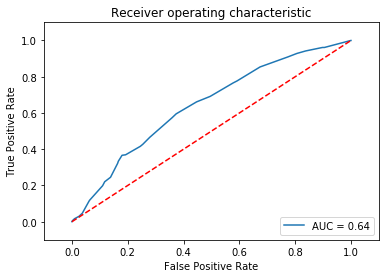

In [59]:
# ROC and AUC
from sklearn.metrics import roc_curve, auc

# Get predicted scores Pr(y=1): Used as thresholds for calculating TP Rate and FP Rate
score = decision_tree_model.predict_proba(X_test)[:, 1]

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, score) # fpr: FP Rate, tpr: TP Rate, thresholds: Pr(y=1)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.title('Receiver operating characteristic')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [60]:
# Plot the decision tree
# Remember you should install package graphviz first
import graphviz

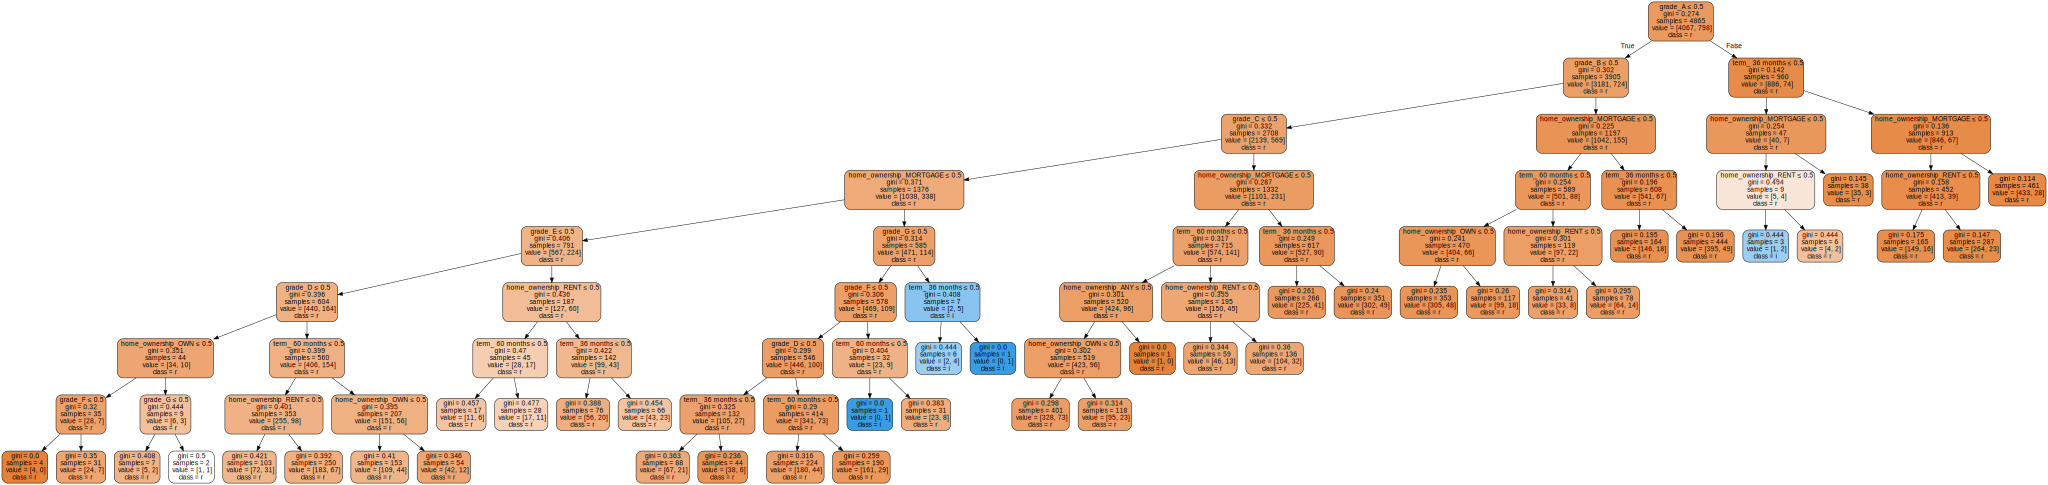

In [61]:
dot_data = tree.export_graphviz(decision_tree_model, out_file=None, feature_names=features, class_names=output, 
                                filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

In [62]:
# Store in .pdf 
graph.render("Lending Club Loan Status") 

'Lending Club Loan Status.pdf'

#### Optional Assignments: 
* Use Titanic data (“train.csv”); Fit the model using `scikit-learn` with different metrics (e.g., information gain, gini index)
* Observe and report the differences (e.g., best features for splitting, tree structure, performance, etc.)
* There are no right or wrong answers. Don't worry. Just report what you've seen. 

**Note:** You may need to do simple data cleaning by yourself, such as binarizing output variable "survived", and transforming categorical variables to dummy variables.

In [63]:
# Titanic dataset
%pwd
titanic = pd.read_csv("./train.csv", low_memory=False)
titanic.head(n=10)

,ID,Age,Age Class,Passenger Class,Gender,No of Siblings or Spouses on Board,No of Parents or Children on Board,Survived
0,1,28,Young Adulthood,Third,Male,0,0,No
1,2,23,Young Adulthood,Second,Male,0,0,No
2,3,5,Childhood,Third,Female,>=2,>=2,Yes
3,4,18,Childhood,Third,Male,0,0,No
4,5,42,Middle Adulthood,Second,Female,0,0,No
5,6,61,Elder Citizen,First,Male,0,0,No
6,7,48,Middle Adulthood,First,Female,1,0,Yes
7,8,1,Childhood,Third,Male,1,1,No
8,9,30,Young Adulthood,Third,Male,0,0,No
9,10,19,Childhood,Second,Male,0,0,No


In [64]:
# Transform categorical features to binary features
age_dummy = pd.get_dummies(titanic['Age Class'], prefix='Ageclass')  
passenger_dummy = pd.get_dummies(titanic['Passenger Class'], prefix='passenger')
titanic['output'] = titanic['Survived'].map(lambda x: 1 if x == 'Yes' else 0)
titanic['gender'] = titanic['Gender'].map(lambda x: 1 if x == 'Male' else 0)

titanic.head()

,ID,Age,Age Class,Passenger Class,Gender,No of Siblings or Spouses on Board,No of Parents or Children on Board,Survived,output,gender
0,1,28,Young Adulthood,Third,Male,0,0,No,0,1
1,2,23,Young Adulthood,Second,Male,0,0,No,0,1
2,3,5,Childhood,Third,Female,>=2,>=2,Yes,1,0
3,4,18,Childhood,Third,Male,0,0,No,0,1
4,5,42,Middle Adulthood,Second,Female,0,0,No,0,0


In [65]:
# Select features and output
features = ['Age']       
output = ['output']

dataset = titanic[features+output]
dataset

,Age,output
0,28,0
1,23,0
2,5,1
3,18,0
4,42,0
5,61,0
6,48,1
7,1,0
8,30,0
9,19,0


In [66]:
dataset = dataset.join([age_dummy, passenger_dummy])
dataset.head()

,Age,output,Ageclass_Childhood,Ageclass_Elder Citizen,Ageclass_Middle Adulthood,Ageclass_Young Adulthood,passenger_First,passenger_Second,passenger_Third
0,28,0,0,0,0,1,0,0,1
1,23,0,0,0,0,1,0,1,0
2,5,1,1,0,0,0,0,0,1
3,18,0,1,0,0,0,0,0,1
4,42,0,0,0,1,0,0,1,0


In [67]:
# Update our features and output
features = dataset.columns[2:]
output = dataset.columns[1]
features

Index([u'Ageclass_Childhood', u'Ageclass_Elder Citizen',
       u'Ageclass_Middle Adulthood', u'Ageclass_Young Adulthood',
       u'passenger_First', u'passenger_Second', u'passenger_Third'],
      dtype='object')

In [68]:
# Fit the model on train data
X = dataset[features]
y = dataset[output]
decision_tree = DecisionTreeClassifier(criterion='entropy')
decision_tree_model = decision_tree.fit(X, y)
decision_tree_model.classes_

# You can also do cross-validation

array([0, 1], dtype=int64)

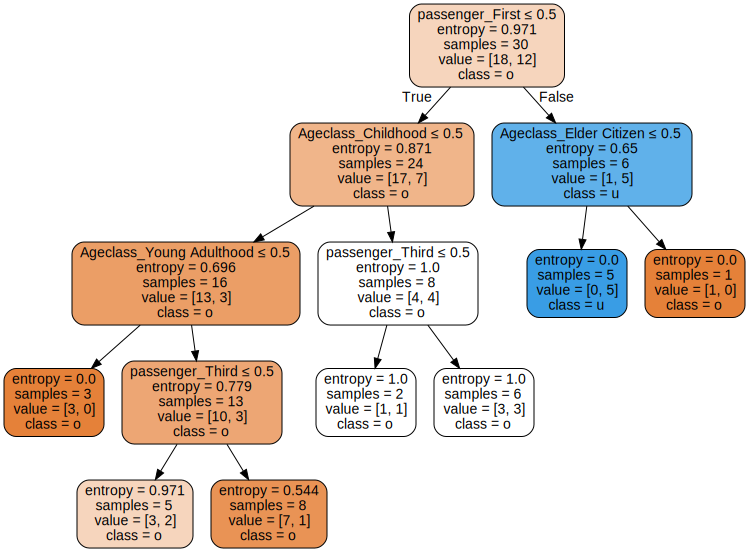

In [69]:
dot_data = tree.export_graphviz(decision_tree_model, out_file=None, feature_names=features, class_names=output, 
                                filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

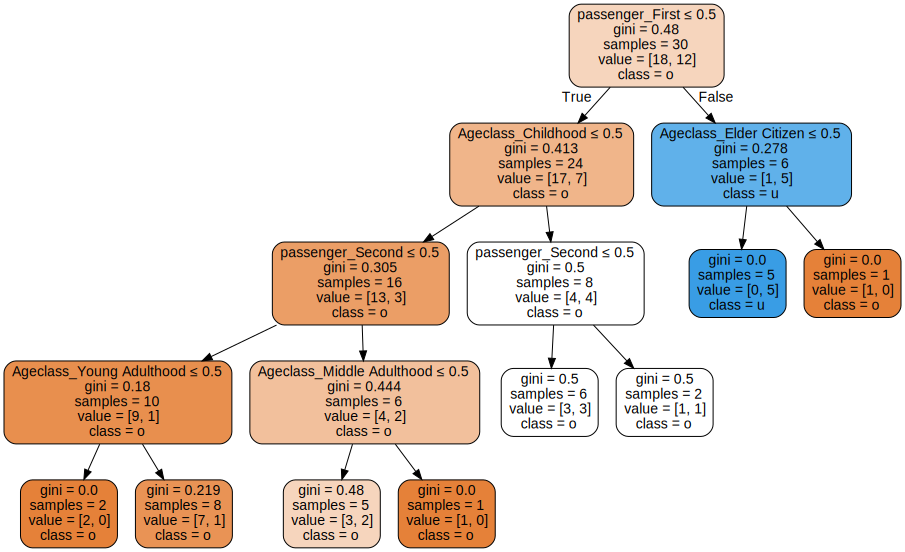

In [70]:
# Fit the model on train data
decision_tree = DecisionTreeClassifier(criterion='gini')
decision_tree_model = decision_tree.fit(X, y)

dot_data = tree.export_graphviz(decision_tree_model, out_file=None, feature_names=features, class_names=output, 
                                filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

## 5 Questions (Just think about them)

### 5.1 What if features are continuous?

* Please refer to text book chapter 8 pp.93

### 5.2 What if output is continuous? 

* Regression Tree

## 6 References

[1] Jason Brownlee, 2018, [Machine Learning Algorithms from Scratch with Python](https://machinelearningmastery.com/machine-learning-algorithms-from-scratch/). <br/>
[2] Peter Harrington, 2012. Machine Learning in Action. Shelter Island, NY: Manning Publications Co.